<a href="https://colab.research.google.com/github/mrbrownnn/smart_traffic_lights/blob/AI_branch/teacher_knowledge_distillation_model_v11x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train original model (YOLOv11-n) for compare models

In [11]:
!nvidia-smi
!pip install ultralytics==8.3.213
!pip install roboflow
!pip install ultralytics==8.3.213 matplotlib seaborn
!nvidia-smi
import matplotlib.pyplot as plt
import seaborn as sns

# prepare model

Fri Nov  7 11:57:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             30W /   70W |     528MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Direction dataset_folder

In [18]:
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn dataset trong Drive (nơi có data.yaml, train/, val/)
DATASET_DIR = "/content/drive/MyDrive/sample_500/v3/sample_500"

# Đường dẫn project (nơi YOLO lưu kết quả train)
PROJECT_DIR = "/content/drive/MyDrive/yolo_traffic_v11"

!mkdir -p {PROJECT_DIR}
%cd {PROJECT_DIR}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/yolo_traffic_v11


In [ ]:
from ultralytics import YOLO
# Load model YOLOv11 nano
model = YOLO('yolo11n.pt')
model.info()
model = YOLO('yolo11n.pt')

results = model.train(
    data=f"{DATASET_DIR}/data_sample.yaml",
    epochs=80,
    imgsz=640,
    batch=16,
    device=0,
    project=PROJECT_DIR,
    name="yolo11n_original"
)
#DES_BASE for 100 random pics
#DATASET_DIR certain 3k5 train pics, 1k7 val pics

YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs
New https://pypi.org/project/ultralytics/8.3.225 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/sample_500/v3/sample_500/data_sample.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train

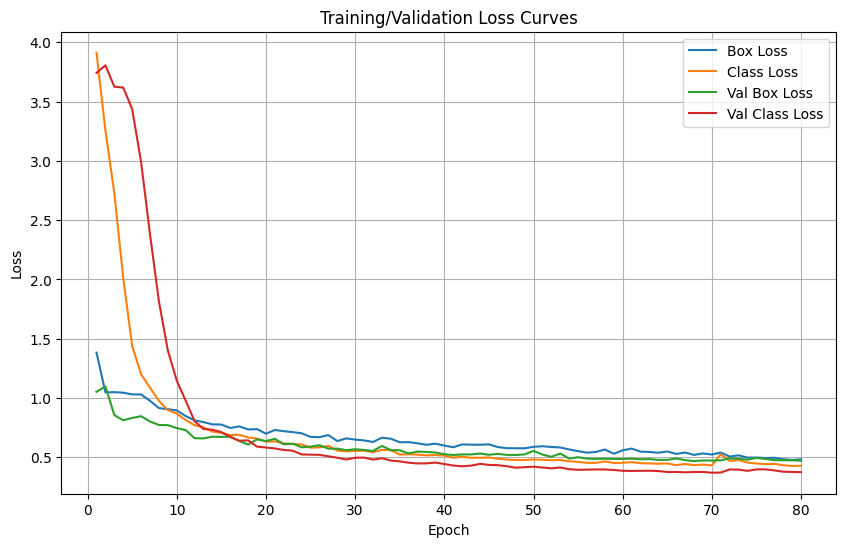

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

metrics_path = "/content/drive/MyDrive/yolo_traffic_v11/yolo11n_original12/results.csv"
df = pd.read_csv(metrics_path)

plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


# mAP50 & mAP50-90

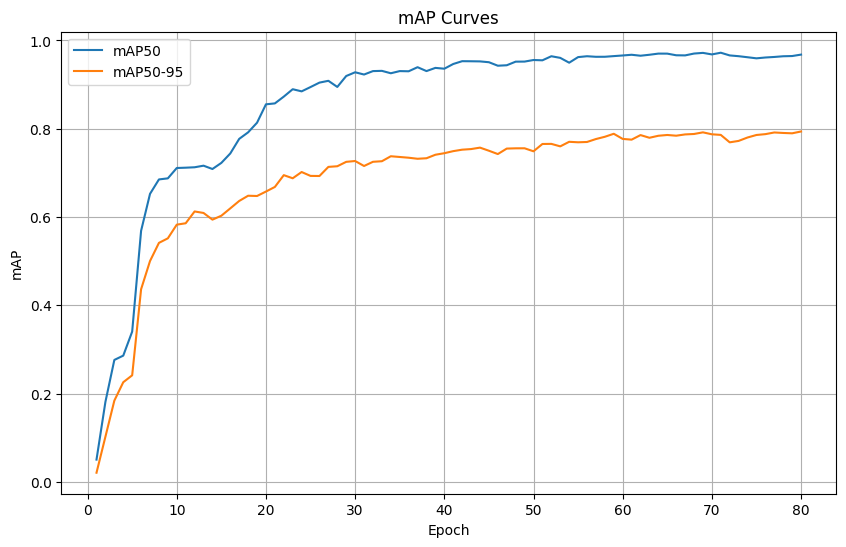

In [3]:
df = pd.read_csv(metrics_path)
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP Curves')
plt.legend()
plt.grid(True)
plt.show()

#F1 Score curve

In [ ]:
plt.figure(figsize=(10,6))
f1 = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])
plt.plot(df['epoch'], f1, label='F1 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.legend()
plt.grid(True)
plt.show()


#Objectness Loss Curve

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')

plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')

plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss (replaces obj_loss)')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss (replaces obj_loss)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('YOLOv11l Loss Curves (Box, Class, DFL)')
plt.legend()
plt.grid(True)
plt.show()


# Result Overall

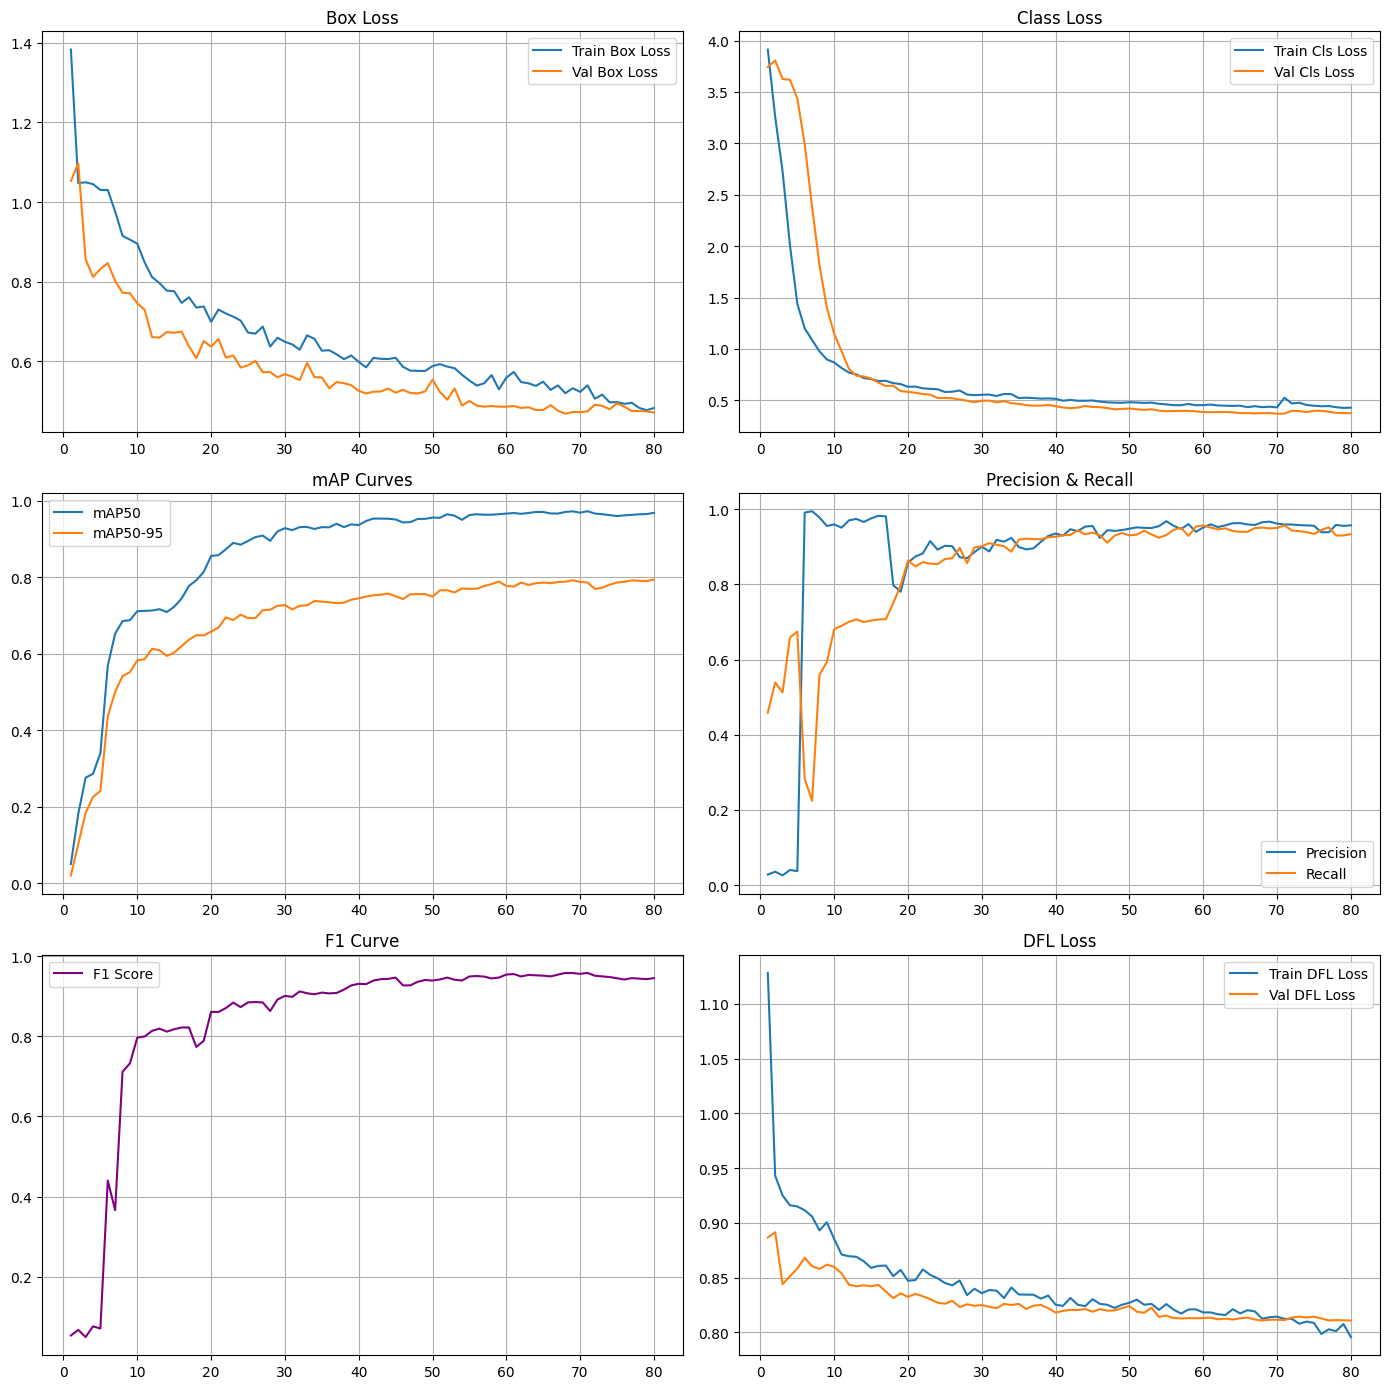

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

axes[0,0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
axes[0,0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
axes[0,0].set_title('Box Loss'); axes[0,0].legend(); axes[0,0].grid()

axes[0,1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
axes[0,1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
axes[0,1].set_title('Class Loss'); axes[0,1].legend(); axes[0,1].grid()

axes[1,0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
axes[1,0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
axes[1,0].set_title('mAP Curves'); axes[1,0].legend(); axes[1,0].grid()

axes[1,1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
axes[1,1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
axes[1,1].set_title('Precision & Recall'); axes[1,1].legend(); axes[1,1].grid()

f1 = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])
axes[2,0].plot(df['epoch'], f1, label='F1 Score', color='purple')
axes[2,0].set_title('F1 Curve'); axes[2,0].legend(); axes[2,0].grid()

axes[2,1].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
axes[2,1].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
axes[2,1].set_title('DFL Loss'); axes[2,1].legend(); axes[2,1].grid()


plt.tight_layout()
plt.show()

#Save the best model

In [ ]:
!yolo val model=/content/drive/MyDrive/yolo_traffic_v11/yolo11l_original9/weights/best.pt, data=/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/test_100/data_test.yaml,imgsz=640 plots=True